<a href="https://colab.research.google.com/github/Spurthi-338/6thSem-ML-Lab/blob/main/1BM23CS338_Lab2_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


First 10 rows:
    longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   
5    -122.25     37.85                52.0        919.0           213.0   
6    -122.25     37.84                52.0       2535.0           489.0   
7    -122.25     37.84                52.0       3104.0           687.0   
8    -122.26     37.84                42.0       2555.0           665.0   
9    -122.25     37.84                52.0       3549.0           707.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  

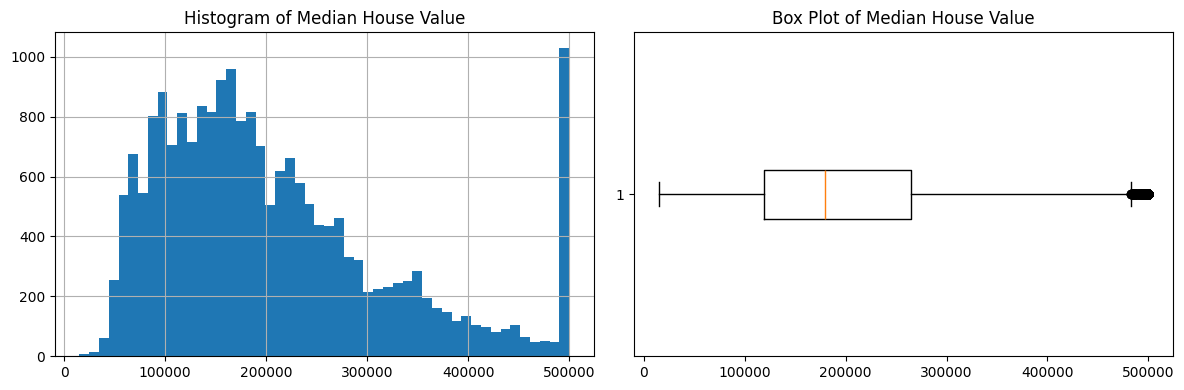


Missing values (%):
 longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64


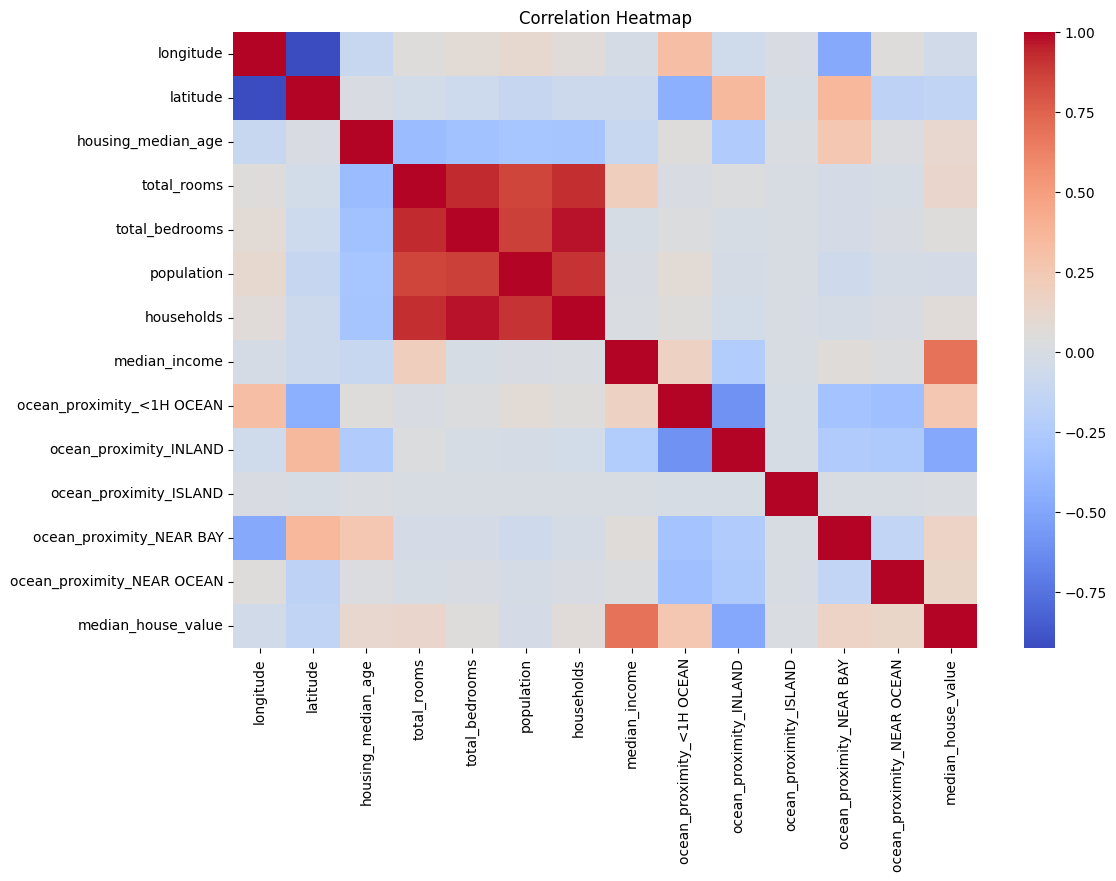

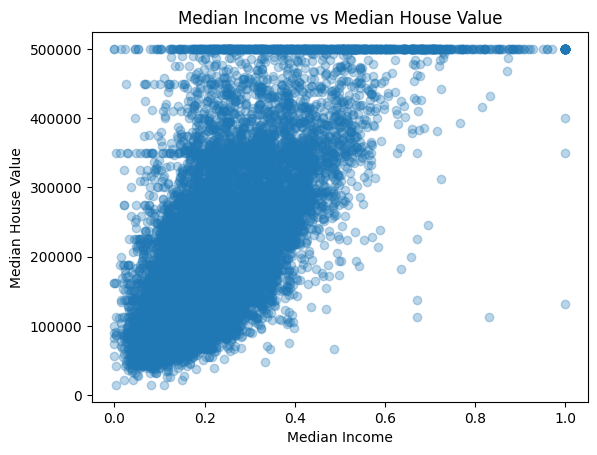


Top 3 positively correlated features:
 median_income                0.687151
ocean_proximity_<1H OCEAN    0.259521
ocean_proximity_NEAR BAY     0.158691
Name: median_house_value, dtype: float64

Most negatively correlated feature:
 ocean_proximity_INLAND   -0.482853
Name: median_house_value, dtype: float64

Model Performance:
RMSE: 67346.88
MAE : 49775.60
R²  : 0.6520


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

URL = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"
housing = pd.read_csv(URL)

print("\nFirst 10 rows:\n", housing.head(10))
print("\nData types:\n", housing.dtypes)
print("\nBasic statistics:\n", housing.describe())

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
housing["median_house_value"].hist(bins=50)
plt.title("Histogram of Median House Value")

plt.subplot(1,2,2)
plt.boxplot(housing["median_house_value"], vert=False)
plt.title("Box Plot of Median House Value")

plt.tight_layout()
plt.show()

print("\nMissing values (%):\n", housing.isnull().mean() * 100)

housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3., 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

split = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=42
)

for train_idx, test_idx in split.split(housing, housing["income_cat"]):
    train_set = housing.iloc[train_idx].copy()
    test_set = housing.iloc[test_idx].copy()

for dataset in (train_set, test_set):
    dataset.drop("income_cat", axis=1, inplace=True)

X_train = train_set.drop("median_house_value", axis=1)
y_train = train_set["median_house_value"]

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"]

num_cols = X_train.select_dtypes(include=[np.number]).columns

imputer = SimpleImputer(strategy="median")
X_train[num_cols] = imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = imputer.transform(X_test[num_cols])

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

minmax = MinMaxScaler()
X_train[num_cols] = minmax.fit_transform(X_train[num_cols])
X_test[num_cols] = minmax.transform(X_test[num_cols])

train_corr = pd.concat([X_train, y_train], axis=1).corr()

plt.figure(figsize=(12,8))
sns.heatmap(train_corr, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

plt.scatter(
    X_train["median_income"],
    y_train,
    alpha=0.3
)
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.title("Median Income vs Median House Value")
plt.show()

target_corr = train_corr["median_house_value"].sort_values(ascending=False)
print("\nTop 3 positively correlated features:\n", target_corr[1:4])
print("\nMost negatively correlated feature:\n", target_corr.tail(1))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_pred = lin_reg.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")
